# This notebook explores the use of a transformer model for predicting beaching locations with the Asia watershed

In [ ]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/dat1/openonic/Drifters'

In [3]:
pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 26.1 MB/s eta 0:00:00


In [4]:
# dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import math

import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch import Tensor
from torch.nn import Transformer
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from timeit import default_timer as timer

import tqdm

from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set(style = 'whitegrid', font_scale = 2.5)

In [5]:
# set random seed
seed = 42
torch.random.manual_seed(seed)
np.random.seed(seed)

In [6]:
# load data
#Asia = pd.read_csv('drifter_data/cluster_16_data.csv').drop(columns = 'HDBSCAN')
# for colab
Asia = pd.read_csv('cluster_16_data.csv').drop(columns = 'HDBSCAN')

## Let's look at our dataset: Asia Beaching Watershed

/usr/local/lib/python3.10/dist-packages/cartopy/mpl/geoaxes.py:1683: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


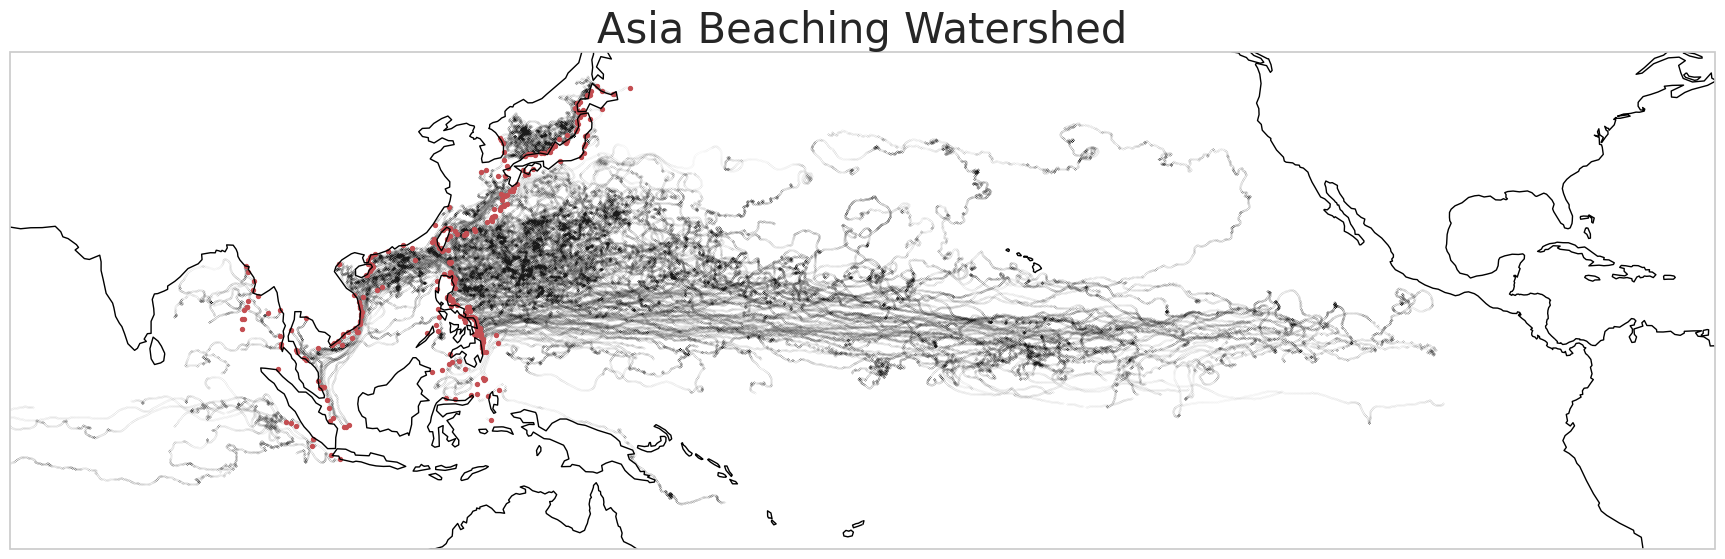

In [7]:
# take a look at the drifter trajectories and beaching locations
beach = Asia
beaching_points = Asia.drop_duplicates(subset='id', keep='last')

point_size = 0.00005

fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-180))
ax.set_extent([120, -120, -20, 50], crs=ccrs.PlateCarree(central_longitude=-180))
ax.coastlines()

# Scatter plot with colors based on the custom colormap
scatter2 = ax.scatter(
    beach['lon'],
    beach['lat'],
    marker='o',
    c='k',
    cmap='viridis',
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system
    s=point_size,
    alpha=0.7
)

ax.scatter(beaching_points['lon'], beaching_points['lat'], color='r', transform=ccrs.PlateCarree(), s = 8)  # Specify the coordinate reference system

plt.title('Asia Beaching Watershed', fontsize = 30)
plt.show()

## Let's prepare and clean our data by:
## 1. Applying a coordinate transform and normalizing
## 2. Splitting the trajectories into sub-sequences and those into source and target sequences
## 3. Collating and splitting into train, test, and validation
## 4. Apply a masking function
##
### Let's start with 1.

We first need to solve the spatial problem inherent to latitude/longitude coordinate data. The distance between one degree of longitude and another is greatest at the equator and smallest at the poles: in fact, as one approaches the poles, the distance in a degree of longitude gets exponentially small. Another problem is that -180 degrees longitude is equal to 180 degrees longitude, this is far from helpful to a neural network. How do we normalize this kind of data? Let's apply a coordinate transform, converting latitude and longitude to the x, y, z coordinates of a sphere (we make the assumption the Earth is a perfect sphere, it isn't, but this shouldn't impact our results in any significant way). The next block of code defines a function to achieve this transformation and shows a 2-d lat/lon map before and 3-d x,y,z sphere after.

In [8]:
# we define a function to transform lat/lon to x,y,z and normalize while we're at it
def coord_transform_normalize(lat_list, lon_list, scaler):

    # convert to radians for use of np.cos, np.sin
    lats_r, lons_r = np.radians(lat_list), np.radians(lon_list)

    # transform lat/lon to x, y, z
    x = np.cos(lons_r) * np.cos(lats_r)
    y = np.sin(lons_r) * np.cos(lats_r)
    z = np.sin(lats_r)

    # stack x,y,z coords
    xyz_coords = np.column_stack((x, y, z))

    # fit scaler to the coords and apply normalization
    norm_xyz_coords = scaler.fit_transform(xyz_coords)

    # split back into x,y,z
    norm_x, norm_y, norm_z = np.hsplit(norm_xyz_coords, 3)

    return norm_x, norm_y, norm_z

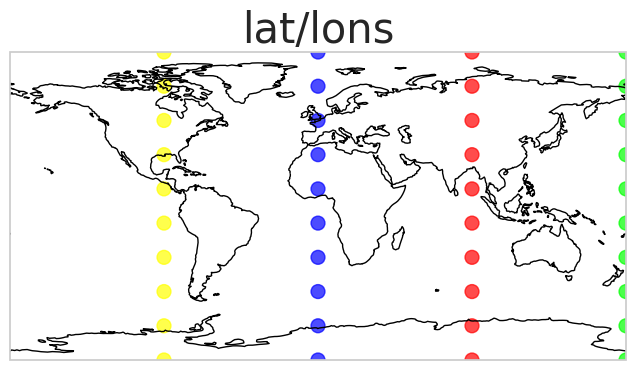

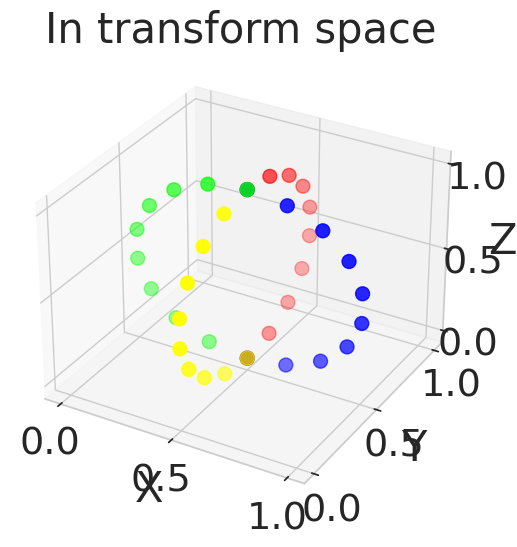

In [9]:
# now we apply this transform to some toy lat/lons:
toy_latitudes_1 = np.array(np.linspace(-90,90,10))
toy_longitudes_1 = np.array(np.ones(10) * 90)

toy_latitudes_2 = np.array(np.linspace(-90,90,10))
toy_longitudes_2 = np.array(np.ones(10) * 180)

toy_latitudes_3 = np.array(np.linspace(-90,90,10))
toy_longitudes_3 = np.array(np.zeros(10))

toy_latitudes_4 = np.array(np.linspace(-90,90,10))
toy_longitudes_4 = np.array(np.ones(10) * -90)


toy_latitudes = np.concatenate((toy_latitudes_1, toy_latitudes_2, toy_latitudes_3, toy_latitudes_4))
toy_longitudes = np.concatenate((toy_longitudes_1, toy_longitudes_2, toy_longitudes_3, toy_longitudes_4))

# initialize MinMaxScaler
toy_scaler = MinMaxScaler()

toy_x, toy_y, toy_z = coord_transform_normalize(toy_latitudes, toy_longitudes, toy_scaler)

# let's plot both x,y,z and lat, lon to visualize how the transform works:
fig = plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree(central_longitude=0))
ax.coastlines()
point_size = 100
color1 = np.array([[255, 0, 0]] * 10) / 255.0  # Red
color2 = np.array([[0, 255, 0]] * 10) / 255.0  # Green
color3 = np.array([[0, 0, 255]] * 10) / 255.0  # Blue
color4 = np.array([[255, 255, 0]] * 10) / 255.0  # Yellow
colors = np.concatenate((color1, color2, color3, color4))
toy_scatter_red =ax.scatter(
    toy_longitudes,
    toy_latitudes,
    marker='o',
    c=colors,
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system
    s=point_size,
    alpha=0.7)

plt.title('lat/lons')
plt.show()

# plot 3D transform
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(toy_x, toy_y, toy_z, s = 100, c= colors)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('In transform space')

plt.show()

In [10]:
# let's apply the coordinate transform and normalization
# initialize MinMaxScaler for coords
coord_scaler = MinMaxScaler()
# apply coordinate transform and normalization to coords
Asia_x, Asia_y, Asia_z = coord_transform_normalize(Asia['lat'], Asia['lon'], coord_scaler)

# initialize MinMaxScaler for time_to_beach
#time_to_beach_scaler = MinMaxScaler()
#Asia_time_to_beach_norm = time_to_beach_scaler.fit_transform(np.array(Asia['time_to_beach']).reshape(-1,1))

Asia_norm = Asia.drop(columns = ['lat', 'lon','time_to_beach']).assign(x = Asia_x, y = Asia_y, z = Asia_z)

### 2. Let's continue by breaking trajectories into sub-sequences of the same length and breaking those into source and target sequences

In [11]:
# group Asia_xyz_norm watershed by unique id and order each row as 'unique id'
# then subsequent feature columns consisting of lists
Asia_by_traj = Asia_norm.groupby('id').agg(lambda x: x.tolist()).reset_index()

# remove trajectories with less than 1000 trajectories
Asia_by_traj['Traj_Length'] = Asia_by_traj['time'].apply(len)
Asia_by_traj = Asia_by_traj[Asia_by_traj['Traj_Length'] >= 1000].drop(columns='Traj_Length')

# FOR REDUCING MODEL SIZE-------------------------------------------------------------------
#Asia_by_traj = Asia_by_traj[100:112]

In [13]:
# helper function for trajectory splitting
def sequence_splitting(feature, dataframe, sequence_length):

    # initialize output
    sequences = []

    # iterate through each trajectory
    for trajectory in dataframe[feature]:

        trajectory = np.array(trajectory) # convert to numpy array for faster processing

        # calculate the starting index to ensure the last sequence fits exactly
        # i.e, remove the first coords such that the length of the trajectory is divisible by the sequence length
        start_idx = len(trajectory) % sequence_length

        # split the trajectory into non-overlapping sequences of length sequence_length
        for i in range(start_idx, len(trajectory), sequence_length):
            if i + sequence_length <= len(trajectory):
                sequences.append(trajectory[i:i+sequence_length])

    return sequences

# helper function for src and tgt splitting
def src_tgt_splitting(feature, percent_src, sequence_length):

    # determine the length of src sequences
    src_length = int(sequence_length * percent_src / 100)

    # assign the first indices to src by percent_src
    src = [sequence[:src_length] for sequence in feature]

    # assign the remaining indices to tgt
    tgt = [sequence[src_length:] for sequence in feature]

    return (src, tgt)

# we define a function to split trajectories into sub-sequences and further split into src and tgt
# note that sequence_length should be equal to or less than min length of trajectories
def split_trajectories(dataframe, sequence_length, percent_src, input_features_list):

    # initialize output lists
    output_features_list = []
    src_tgt_features = []

    # split features of each trajectory into sequences of length sequence_length
    for feature in input_features_list:

      output_features_list.append(sequence_splitting(feature, dataframe, sequence_length))


    # split into src and tgt by percent_src
    for feature in output_features_list:
      src_tgt_features.append(src_tgt_splitting(feature, percent_src, sequence_length))

    return src_tgt_features

# perform the split into sequences of length 1000, then split sequences into 80% src
sequence_length = 1000
percent_src = 50 # 50/50
src_tgt_features = split_trajectories(Asia_by_traj, sequence_length, percent_src, ['x','y','z'])

In [14]:
np.shape(src_tgt_features)

(3, 2, 1241, 500)

In [17]:
x_src_tgt = src_tgt_features[0]
y_src_tgt = src_tgt_features[1]
z_src_tgt = src_tgt_features[2]

Text(0.5, 0.92, 'Sequences in Transform Space divided into Black SRC and Red TGT')

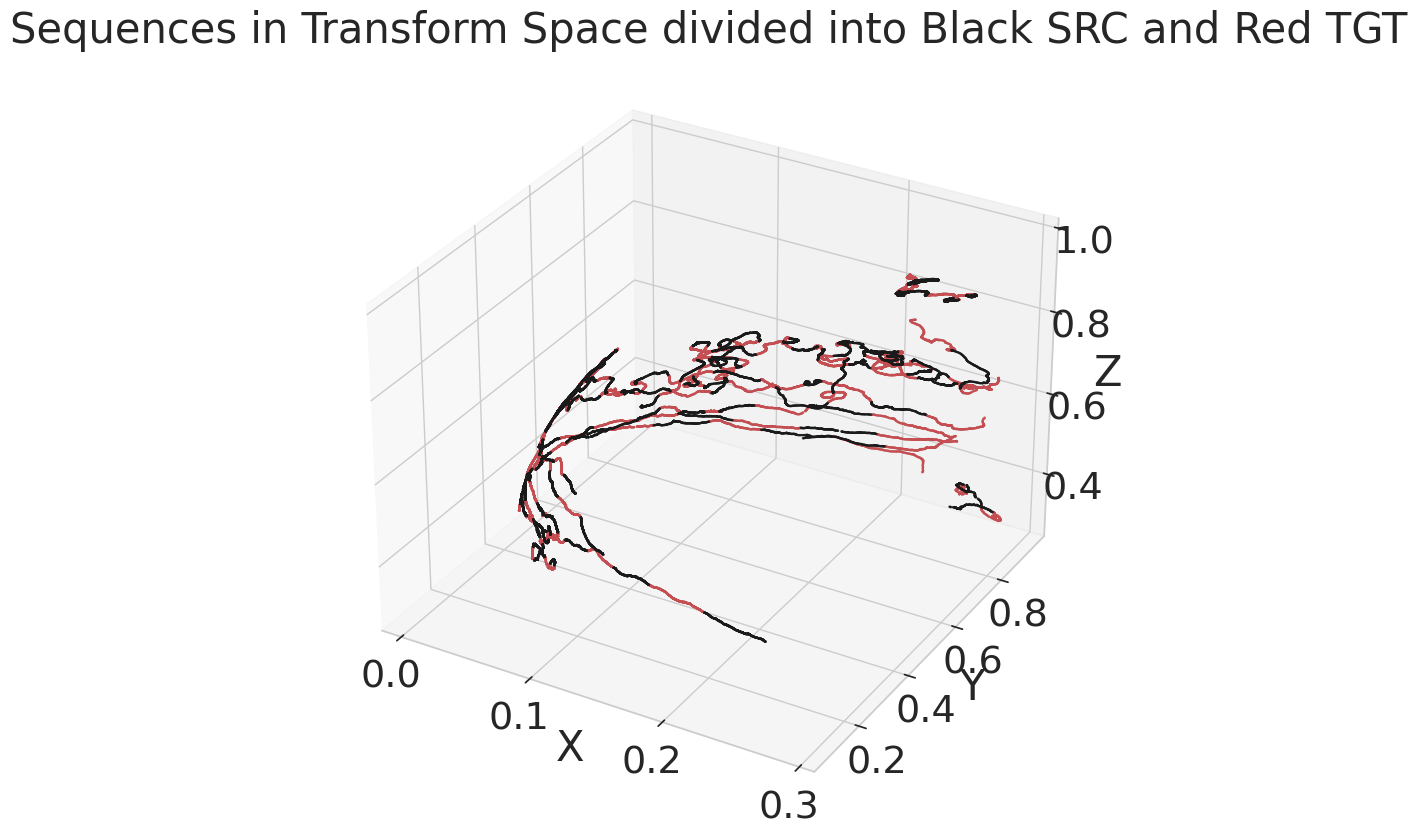

In [18]:
# plot 3D transform
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_src_tgt[0][0:100], y_src_tgt[0][0:100],
           z_src_tgt[0][0:100], s = 0.5, color ='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# plot beaching points in red
ax.scatter(x_src_tgt[1][0:100], y_src_tgt[1][0:100],
           z_src_tgt[1][0:100], s = 0.5, color ='r')


plt.title('Sequences in Transform Space divided into Black SRC and Red TGT')

In [12]:
# reduce the number of data by taking windows and averaging
def window_avg(data, window_size):
    # reshape the data to facilitate window averaging
    reshaped_data = data[:len(data)//window_size * window_size].reshape(-1, window_size)

    # calculate the mean along the last axis
    averaged_data = np.mean(reshaped_data, axis=1)

    return averaged_data

# get data from dataframe and apply reduction
window_size = 2 # set window_size

# apply window averaging to src
x_src = [window_avg(sequence, window_size) for sequence in x_src_tgt[0]]
y_src = [window_avg(sequence, window_size) for sequence in y_src_tgt[0]]
z_src = [window_avg(sequence, window_size) for sequence in z_src_tgt[0]]

# apply window averaging to tgt
x_tgt = [window_avg(sequence, window_size) for sequence in x_src_tgt[1]]
y_tgt = [window_avg(sequence, window_size) for sequence in y_src_tgt[1]]
z_tgt = [window_avg(sequence, window_size) for sequence in z_src_tgt[1]]

# combine src x,y,z together, stack, and transpose into shape [sequences, length, x y z]
all_src = np.transpose(np.stack([x_src, y_src, z_src], axis = 0), (1,2,0))
all_tgt = np.transpose(np.stack([x_tgt, y_tgt, z_tgt], axis = 0), (1,2,0))

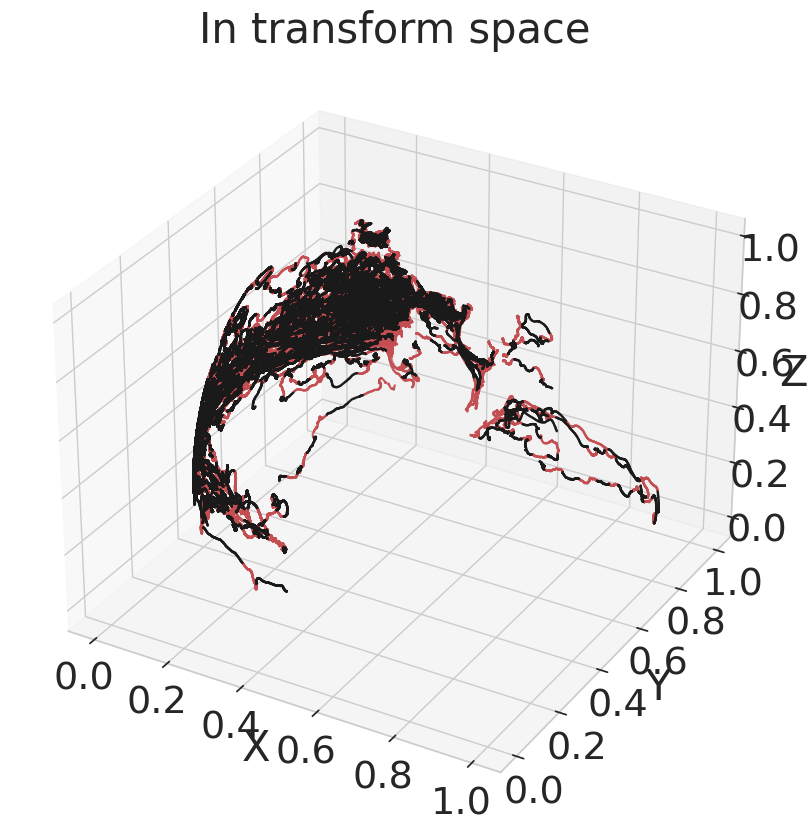

In [13]:
# let's take a look at the output of coordinate transformation, normalization, sequencing, and splitting into src and tgt:
# x
Asia_src_x = all_src[:,:,0]
Asia_tgt_x = all_tgt[:,:,0]

# y
Asia_src_y = all_src[:,:,1]
Asia_tgt_y = all_tgt[:,:,1]

# z
Asia_src_z = all_src[:,:,2]
Asia_tgt_z = all_tgt[:,:,2]

# plot 3D transform
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Asia_src_x, Asia_src_y,
           Asia_src_z, s = 0.5, color ='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# plot beaching points in red
ax.scatter(Asia_tgt_x, Asia_tgt_y,
           Asia_tgt_z, s = 0.5, color ='r')
plt.title('In transform space')

plt.show()

### 3. Let's collate and split into train, test, and validation

In [14]:
# indices values for padding, start of trajectory, and end of trajectory
PAD_IDX, BOS_IDX, EOS_IDX = -1, -2, -3

In [15]:
np.shape(all_src)

(1241, 250, 3)

In [16]:
# split data and input lengths into training and remaining (for validation and testing)
train_src, remaining_src, train_tgt, remaining_tgt = train_test_split(
    all_src, all_tgt, train_size = 1201, random_state = 42) #1201

# split the remaining data and input lengths into validation and test sets
val_src, test_src, val_tgt, test_tgt = train_test_split(
    remaining_src, remaining_tgt, test_size = 20, random_state = 42) # 20

# collate (combine src and tgt into single tensor)
# train
#train_src_collated, train_tgt_collated = collate_fn(train_src), collate_fn(train_tgt)

# val
#val_src_collated, val_tgt_collated = collate_fn(val_src), collate_fn(val_tgt)

# test
#test_src_collated, test_tgt_collated = collate_fn(test_src), collate_fn(test_tgt)

# save as train, val, test of shape:[trajectories (batch), src or tgt, length (of trajectories), x y z (coordinate dimensions)]
training_data = [(torch.tensor(src, dtype=torch.float32).cuda(), torch.tensor(tgt, dtype=torch.float32).cuda()) for src, tgt in zip(train_src, train_tgt)]
validation_data = [(torch.tensor(src, dtype=torch.float32).cuda(), torch.tensor(tgt, dtype=torch.float32).cuda()) for src, tgt in zip(val_src, val_tgt)]
testing_data = [(torch.tensor(src, dtype=torch.float32).cuda(), torch.tensor(tgt, dtype=torch.float32).cuda()) for src, tgt in zip(test_src, test_tgt)]

### 4. Let's define the masking function

In [17]:
# Helper function to generate subsequent mask
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz)), diagonal=1) == 1)  # Generate upper triangular matrix
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask.sum(dim=(-1, -2), keepdim=True)  # Squeeze unnecessary dimensions

# Mask function
def create_mask(src, tgt, pad_idx = PAD_IDX):
    # Get src and tgt lengths assuming shape [batch, seq_len, features]
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    # Generate tgt mask
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)

    # Source mask can be None unless needed
    src_mask = None

    # Padding masks should be [batch_size, seq_len]
    #src_padding_mask = (src == pad_idx).all(dim=2).transpose(0, 1)  # Assuming PAD_IDX applies across all features
    #tgt_padding_mask = (tgt == pad_idx).all(dim=2).transpose(0, 1)

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [18]:
# Helper function to generate subsequent mask
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt, pad_idx = PAD_IDX):
    # Get src and tgt lengths assuming shape [batch, seq_len, features]
    # with dataloader:
    #src_seq_len = src.shape[1]
    #tgt_seq_len = tgt.shape[0]
    #num_features = src.shape[2]  # Assuming src and tgt have the same number of features

    # new model without dataloader
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]
    num_features = src.shape[1]

    # Generate tgt mask
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)

    # Source mask can be None unless needed
    src_mask = None

    # Padding masks should be [batch_size, seq_len, num_features]
    #src_padding_mask = (src == pad_idx).all(dim=2).transpose(0, 1)  # Shape: [batch_size, seq_len]
    #src_padding_mask = src_padding_mask.unsqueeze(-1).expand(-1, -1, num_features)  # Expand to [batch_size, seq_len, num_features]

    #tgt_padding_mask = (tgt == pad_idx).all(dim=2).transpose(0, 1)  # Shape: [batch_size, seq_len]
    #tgt_padding_mask = tgt_padding_mask.unsqueeze(-1).expand(-1, -1, num_features)  # Expand to [batch_size, seq_len, num_features]

    src_padding_mask = None
    tgt_padding_mask = None

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

### Define training and evaluation functions

In [19]:
# we define a function to train the model for a single epoch
def train_epoch(model, optimizer, training_data):
    model.train()
    loss_list = []
    train_iter = training_data
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, shuffle=False) # set shuffle to False as the data is sequential in time and space
    for src, tgt in train_dataloader:
    #for src, tgt in train_dataloader:

        #src = src.to(device)
        #tgt = tgt.to(device)
       # print(np.shape(tgt))
        tgt_input = tgt[0, :-1, :]  # Use all but the last step as input
        tgt_out = tgt[0, 1:, :]     # Use all but the first step as output
        #tgt_input = tgt[:, :-1, :]
        #print(np.shape(tgt_input))

        #tgt_input = tgt

        # Since we're training, recall we need to mask our input
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)


        # What do you think the model does with the masks when it's in evaluation mode?
        logits = model(src[0], tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        #tgt_out = tgt[:, 1:, :]

        #tgt_out = tgt

        # Reshape logits and tgt_out to have the same batch size
        #logits = logits.reshape(-1, logits.shape[-1])
        #tgt_out = tgt_out.reshape(-1)

        # Reshape logits to have shape [batch_size * seq_len, num_features]
        #logits_reshaped = logits.reshape(-1, logits.shape[-1])

        # Reshape tgt_out to have shape [batch_size * seq_len, num_features]
        #tgt_out_reshaped = tgt_out.reshape(-1, tgt_out.shape[-1])

        loss = loss_fn(logits, tgt_out)
        #loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        max_norm = 1
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)  # Clip the gradients

        optimizer.step()
        loss_list.append(loss.item())

    return loss_list

# Define a function to evaluate the model
def evaluate(model, eval_data):
    model.eval()

    # initialize out-lists
    loss_list = []
    logits_list = []
    tgt_out_list = []

    # define eval_iter
    eval_iter = eval_data

    # use DataLoader to break into batches
    val_dataloader = DataLoader(eval_iter, batch_size=BATCH_SIZE, shuffle=False)

    for src, tgt in val_dataloader:
        #src = src.to(DEVICE)
        #tgt = tgt.to(DEVICE)

        tgt_input = tgt[0, :-1, :]  # Use all but the last step as input
        tgt_out = tgt[0, 1:, :]     # Use all but the first step as output

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        logits = model(src[0], tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        # save each loss term
        loss = loss_fn(logits, tgt_out)
        loss_list.append(loss.item())

        # save each model output term
        logits_list.append(logits)

        # save each tgt_out term
        tgt_out_list.append(tgt_out)

    return loss_list, logits_list, tgt_out_list

### Define transformer model

In [20]:
# Define the transformer model
class Drifter_Transformer(nn.Module):
    def __init__(self,
                 num_encoder_layers,
                 num_decoder_layers,
                 embedding_size,
                 input_dim,
                 num_heads,
                 dim_feedforward=512,
                 dropout=0.1):
        super(Drifter_Transformer, self).__init__()

        # linear transformation of input_dim (coords) into higher space ()
        self.embedding = nn.Linear(input_dim, embedding_size)

        self.transformer = Transformer(d_model=embedding_size,
                                       nhead=num_heads,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(embedding_size, 3)  # Output 3 values for (x, y, z)

    def forward(self,
                src,
                tgt,
                src_mask,
                tgt_mask,
                src_padding_mask,
                tgt_padding_mask,
                memory_key_padding_mask):

        # Project input features to d_model dimensions
        src = self.embedding(src)
        tgt = self.embedding(tgt)

        outs = self.transformer(src, tgt, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        #print(outs)
        return self.generator(outs)

## Define hyperparameters

In [21]:
# Define your hyperparameters
SRC_LENGTH = np.shape(train_src)[2]
TGT_LENGTH = np.shape(train_tgt)[2]
INPUT_SIZE = 3
EMB_SIZE = 550
NUM_HEADS = 10 # Why 8, or 10? What do you expect to happen if we increase this parameter?
# increasing num heads can increase the model's capacity to understanding diverse
# representations, allowing the heads to increase the model's learning complexity.
# It may become redundant, though, and lead to slow run times without much benefit.
# It may increase the performance, or not. Trial and error!
FFN_HID_DIM = 512
BATCH_SIZE = 1
NUM_ENCODER_LAYERS = 1
NUM_DECODER_LAYERS = 1
NUM_EPOCHS = 8

# Define your model, loss function, and optimizer
transformer = Drifter_Transformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 INPUT_SIZE, NUM_HEADS, FFN_HID_DIM)
transformer = transformer.cuda()
model = transformer

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

#transformer = transformer.to(device)

loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

# initialize train and val loss lists
train_loss_list = []
val_loss_list = []

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Now, we train the model!

In [22]:
# train the model
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, training_data)
    train_loss_list.extend(train_loss)
    end_time = timer()
    val_loss, _, _ = evaluate(transformer, validation_data)
    val_loss_list.extend(val_loss)
    print((f"Epoch: {epoch}, Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Epoch time = 14.097s
Epoch: 2, Epoch time = 12.977s
Epoch: 3, Epoch time = 21.352s
Epoch: 4, Epoch time = 13.058s
Epoch: 5, Epoch time = 12.960s
Epoch: 6, Epoch time = 13.049s
Epoch: 7, Epoch time = 13.124s
Epoch: 8, Epoch time = 13.123s


final training loss: 0.00924997590482235
final validation loss: 0.00025211364845745265


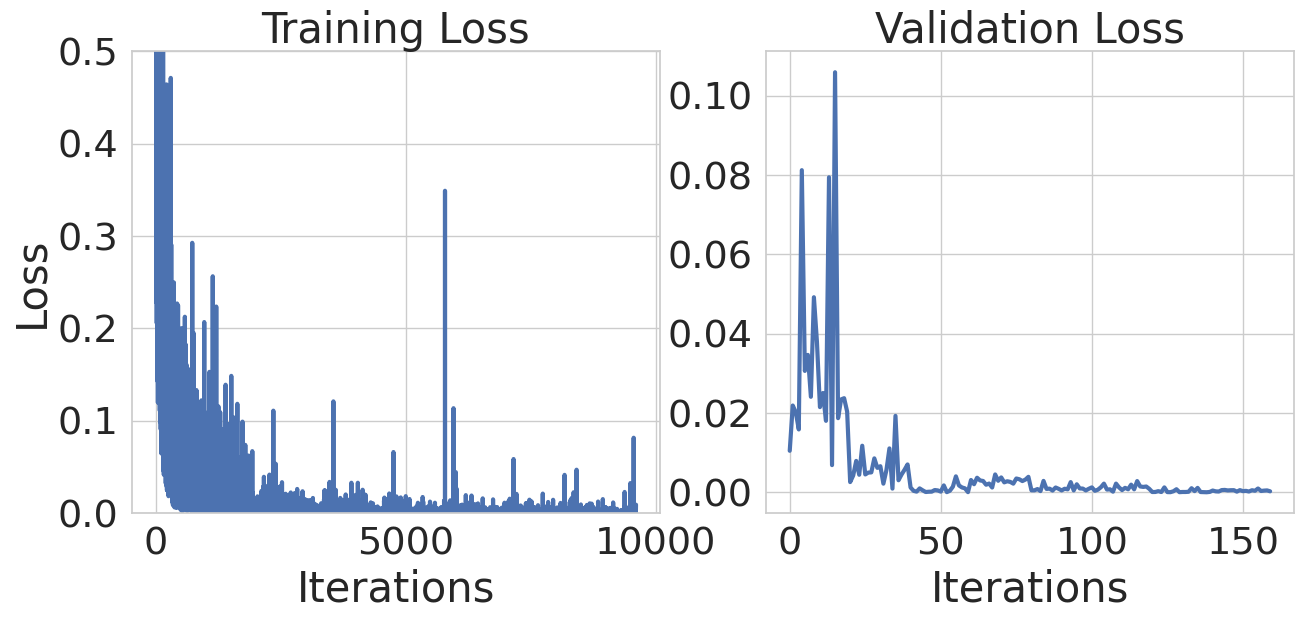

In [36]:
# let's visualize the training and validation loss
print('final training loss: '+ str(train_loss_list[-1]))
print('final validation loss: '+ str(val_loss_list[-1]))

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(train_loss_list, linewidth=3, label='Training Loss')
axs[0].set_ylabel("Loss")
axs[0].set_xlabel("Iterations")
axs[0].set_title('Training Loss')
axs[0].set_ylim(0,0.5)

axs[1].plot(val_loss_list, linewidth=3, label='Validation Loss')
#axs[1].set_ylabel("Validation Loss")
axs[1].set_xlabel("Iterations")
axs[1].set_title('Validation Loss')

plt.show()

## let's test our model with our test data now!

In [24]:
# test with the test data

# initialize test_loss_list
test_loss_list = []

# run model with test data
test_loss, model_outputs, test_targets = evaluate(transformer, testing_data)

# append test_loss to the list
test_loss_list.extend(test_loss)

# print the final test loss value
print('final testing loss: '+ str(test_loss_list[-1]))

final testing loss: 0.0005482326378114522


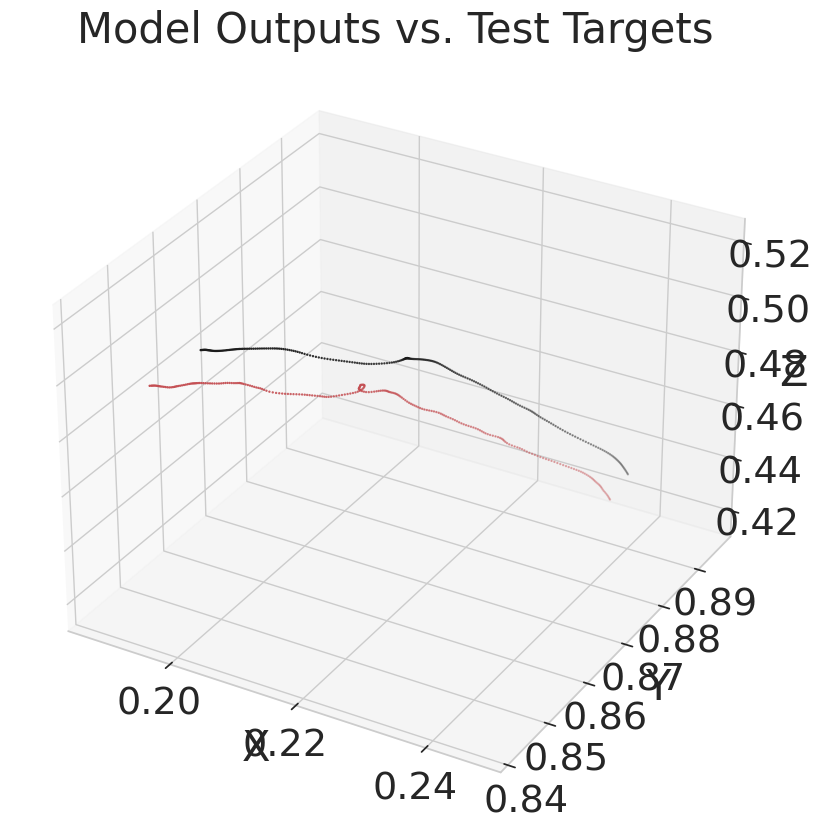

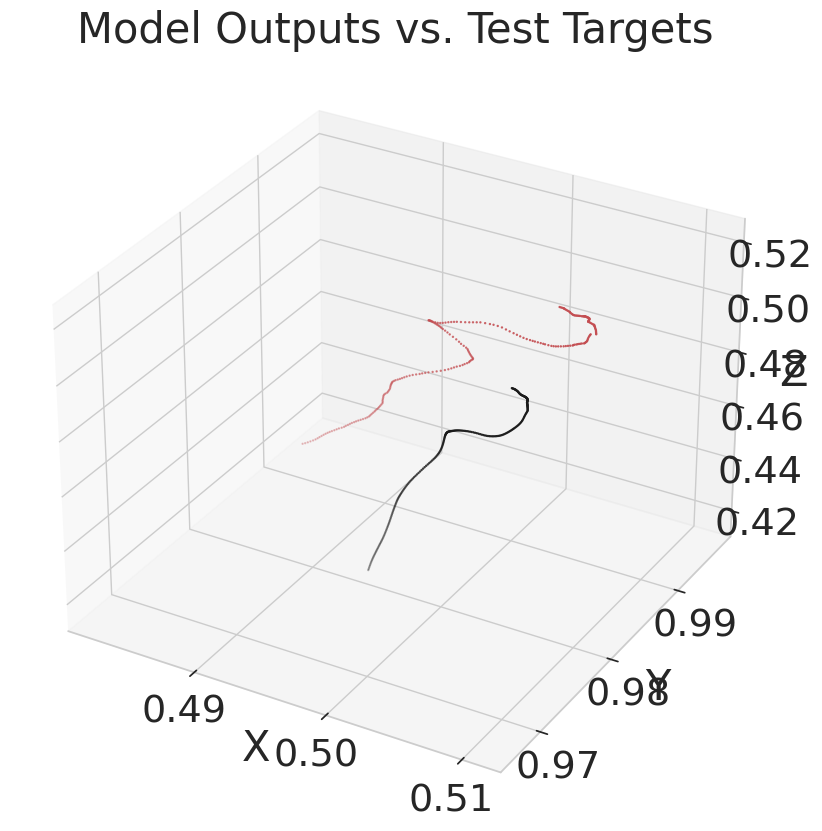

In [34]:
# Convert tensors to numpy arrays
model_outputs_np = model_outputs[0].cpu().detach().numpy()
test_targets_np = test_targets[0].cpu().detach().numpy()

model_outputs_np2 = model_outputs[1].cpu().detach().numpy()
test_targets_np2 = test_targets[1].cpu().detach().numpy()


# Extract the x, y, and z coordinates from both tensors
model_outputs_x = model_outputs_np[:, 0]
model_outputs_y = model_outputs_np[:, 1]
model_outputs_z = model_outputs_np[:, 2]

test_targets_x = test_targets_np[:, 0]
test_targets_y = test_targets_np[:, 1]
test_targets_z = test_targets_np[:, 2]

model_outputs_x2 = model_outputs_np2[:, 0]
model_outputs_y2 = model_outputs_np2[:, 1]
model_outputs_z2 = model_outputs_np2[:, 2]

test_targets_x2 = test_targets_np2[:, 0]
test_targets_y2 = test_targets_np2[:, 1]
test_targets_z2 = test_targets_np2[:, 2]

# Plot the model outputs and test targets in 3D space
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(model_outputs_x, model_outputs_y, model_outputs_z, s = 0.5, color ='k', label='Model Outputs')
ax.scatter(test_targets_x, test_targets_y, test_targets_z, s = 0.5, color ='r', label='Test Targets')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Model Outputs vs. Test Targets')

plt.show()
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(model_outputs_x2, model_outputs_y2, model_outputs_z, s = 0.5, color ='k', label='Model Outputs')
ax.scatter(test_targets_x2, test_targets_y2, test_targets_z, s = 0.5, color ='r', label='Test Targets')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Model Outputs vs. Test Targets')

plt.show()


### to convert back to lat/lon coordinates and visualize where the model predicted beaching, we need to perform the inveres of the coord_transform_normalize function on the test output

In [25]:
# we define a function to transform normalized x,y,z output to lat/lon coordinates
def inverse_coord_transform_normalize(model_outputs):

    # initialize lat/lon list
    lon_list = []
    lat_list = []

    for sequence in model_outputs:
        for coord in sequence:

            # convert from tensor to list
            coord_list = coord.tolist()

            # undo MinMaxScaler normalization
            coord_list_denorm = coord_scaler.inverse_transform(np.array(coord_list).reshape(-1, 3)).squeeze()

            # extract x, y, z coords
            x = coord_list_denorm[0]
            y = coord_list_denorm[1]
            z = coord_list_denorm[2]

            # transform x, y, z back into lat/lon
            lons = np.degrees(np.arctan2(y, x))
            lats = np.degrees(np.arcsin(z))

            # append to a list
            lon_list.append(lons)
            lat_list.append(lats)

    return lat_list, lon_list

In [26]:
# apply function to convert x,y,z normalized values to denormalized lat/lon coords
# model outputs
lat_outputs, lon_outputs = inverse_coord_transform_normalize(model_outputs)

# targets
lat_targets, lon_targets = inverse_coord_transform_normalize(test_targets)

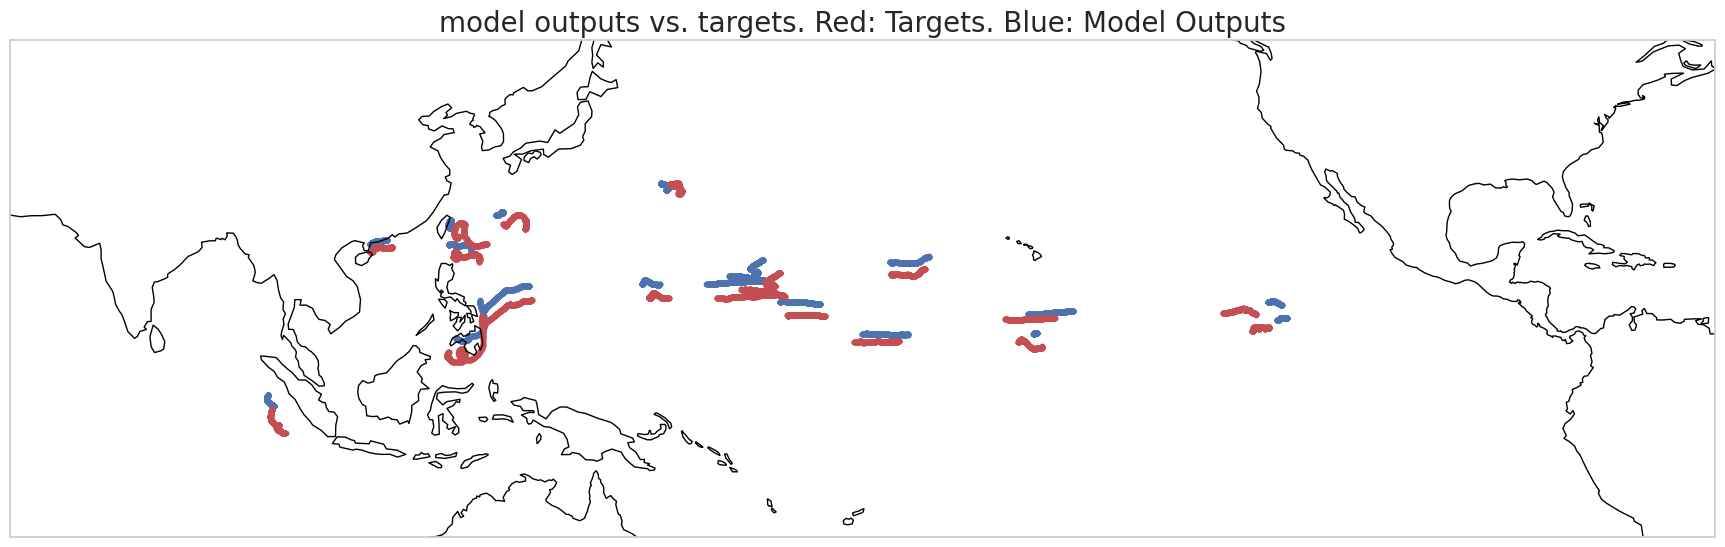

In [27]:
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-180))
ax.set_extent([120, -120, -20, 50], crs=ccrs.PlateCarree(central_longitude=-180))
ax.coastlines()

point_size = 10

# Scatter plot with colors based on the custom colormap
# model outputs
scatter_targets = ax.scatter(
    lon_outputs,
    lat_outputs,
    marker='o',
    c='b',
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system
    s=point_size,
    alpha=1
)

# targets
scatter_targets = ax.scatter(
    lon_targets,
    lat_targets,
    marker='o',
    c='r',
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system
    s=point_size,
    alpha=1
)

plt.title('model outputs vs. targets. Red: Targets. Blue: Model Outputs', fontsize = 20)
plt.show()

Text(0.5, 1.0, 'closer view of results')

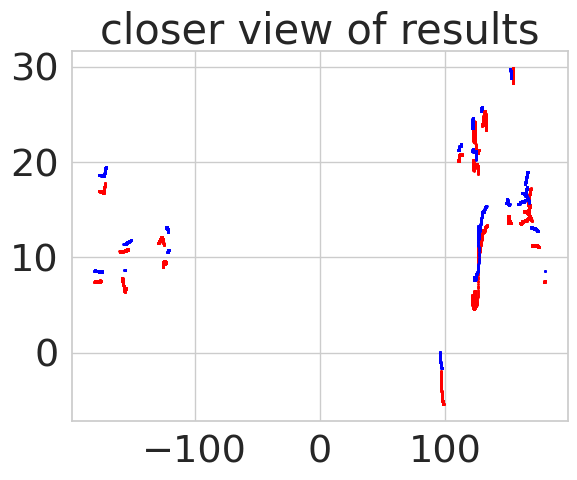

In [28]:
plt.scatter(lon_targets, lat_targets,s = 1, c = 'red')
plt.scatter(lon_outputs, lat_outputs, s = 1, c = 'blue')

plt.title('closer view of results')